In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import pandas as pd


In [45]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.290153649828586e-06
_gain = np.sqrt(450696654238001.6 )
_K = 6.746007702007992e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.32e-3
_v_force = 6*np.pi*_r*_viscous

print("momentum relation time is " + str(_m/_v_force))


momentum relation time is 5.311361904557549e-06


In [46]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD

def compute_init_msd(sequence):
    MS = np.zeros(len(sequence))
    for i in range(1, len(MS)):
        MS[i] = (sequence[0] - sequence[i])**2
        #print(np.abs(sequence[0] - sequence[1]) / np.abs(sequence[50] - sequence[55]))
    return MS

def compute_init_msd2(time_trace):

    n = len(time_trace)

    msd_ = [(time_trace[k]-time_trace[0])**2 for k in range(n)]
    return np.array(msd_)


In [47]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print("tp is " + str(t_p))
    print(t_f)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    print("use_mass is " + str(use_mass))
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))



In [48]:
# SIMULATIONS
series_percent = 20
chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]
print(position_cols)
timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")
positions_sim = np.array(positions_sim[int(len(positions_sim)/100):])
velocities_sim = np.array(positions_sim[int(len(velocities_sim)/100):])

bin_num_sim = 40
fs_sim = 1/(timestep_sim * bin_num_sim)
print(1/fs_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)


# GET THE EQ MSD
all_msd_sim = []
lag_times_sim = 0
for series in traces_sim:
    msd, lag_times_sim = compute_msd(series[:int(len(series)*series_percent/100)], timestep_sim*bin_num_sim)
    all_msd_sim.append(msd)

eq_msd_sim = np.mean(all_msd_sim, axis=0)



['Position 0']
2.1245447618230194e-08


100%|██████████| 297689/297689 [01:36<00:00, 3098.17it/s] 


In [49]:
import math
from scipy import constants

def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)
#
def stat_hydro_msd(t, roots):
    return 2*constants.k*_temp*c_inverse_form(t, roots)

def v_t1_v_t2(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))



In [50]:
# speeds = [0, .5, .75, 1, 2, 4]
speeds = [0, .5, 1, 2]
# traces_per_speed = [0, 0, 0, 0, 0, 0]
traces_per_speed = [0, 0, 0, 0]
# GET THE VAR INT MSD

sim_speeds_msds = []

# speed_tol = [.015, .015, .015, .015, .015, .015]
speed_tol = [.01, .01, .03, .05]
lag_times_speed_sim = 0

In [51]:
times_analytic = np.logspace(-7, -2, 200)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)
num_samples = 10000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed_no_half = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []
for speed in speeds:
    print("Speed X")
    for i in tqdm(range(num_samples)):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))


Speed X


100%|██████████| 10000/10000 [00:32<00:00, 309.43it/s]


Speed X


100%|██████████| 10000/10000 [00:32<00:00, 310.55it/s]


Speed X


100%|██████████| 10000/10000 [00:32<00:00, 311.57it/s]


Speed X


100%|██████████| 10000/10000 [00:32<00:00, 312.07it/s]


In [52]:
# LOOK FOR SPECIFIC SPEEDS
# SIM PART 3

for s in range(len(speeds)):
    #Comment out SIM
    # all_speeds_msd_data = []
    init_len_sim = int(len(traces_sim[0])/10)

    msd_sum = np.zeros(init_len_sim)
    total_idx = 0
    lag_times_speed_sim = np.arange(init_len_sim)/fs_sim
    for i in range(len(traces_sim)):
        speed_idxs_sim = []
        print("std of sim vel " + str(np.std(v_traces_sim[i])))
        print("sqrt kbt/m " + str(np.sqrt(_k_b*_temp/_m)))
        v_tolerance = (speeds[s] * np.std(v_traces_sim[i]))
        speed_tolerance = speed_tol[s] * np.std(v_traces_sim[i])
        v_indices_sim = np.where((v_traces_sim[i] < v_tolerance + speed_tolerance) & (v_traces_sim[i] > v_tolerance - speed_tolerance))[0]
        print("speed idx sim: " + str(len(v_indices_sim)))

        for idx in v_indices_sim:
            if idx + init_len_sim < len(traces_sim[i]) and (idx > init_len_sim):
                speed_idxs_sim.append(idx)

        print("total idx speed sim: " + str(len(speed_idxs_sim)))

        for idx in tqdm(speed_idxs_sim):
            msd = compute_init_msd2(traces_sim[i][idx:idx+init_len_sim])
            msd_sum += msd
            total_idx += 1

    sim_speeds_msds.append(msd_sum/total_idx)

std of sim vel 8.054542662635196e-09
sqrt kbt/m 0.0003128428516849306
speed idx sim: 433669
total idx speed sim: 341797


 16%|█▌        | 53962/341797 [19:26<1:43:41, 46.27it/s]


KeyboardInterrupt: 

tp is 5.311361904557549e-06
4.1092255866598664e-06
use_mass is 4.133314304324241e-14


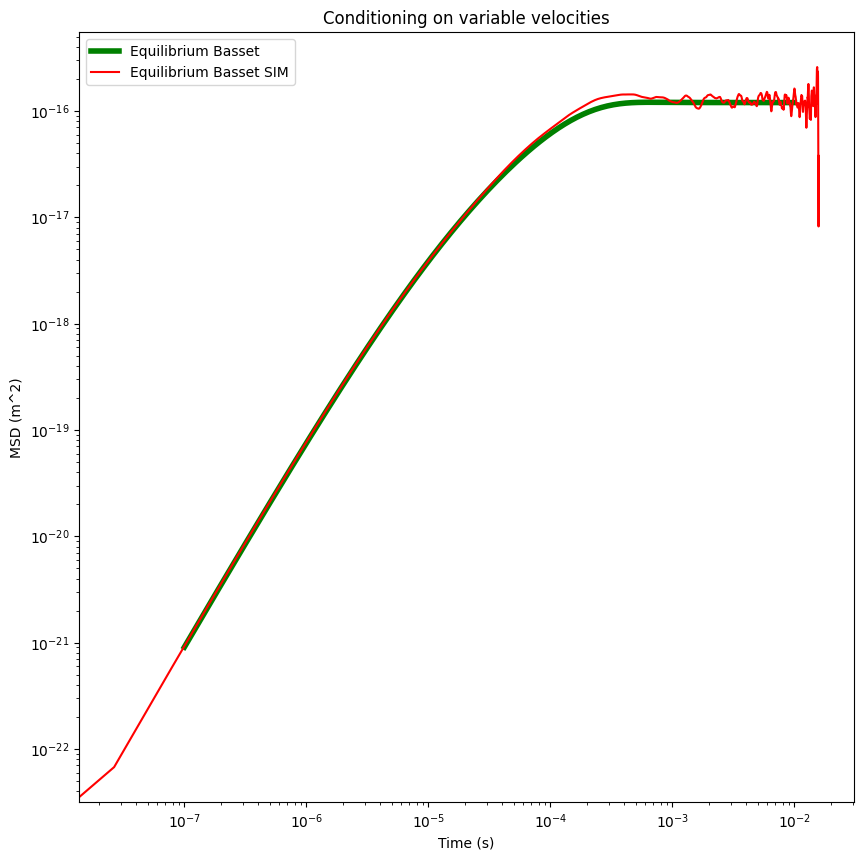

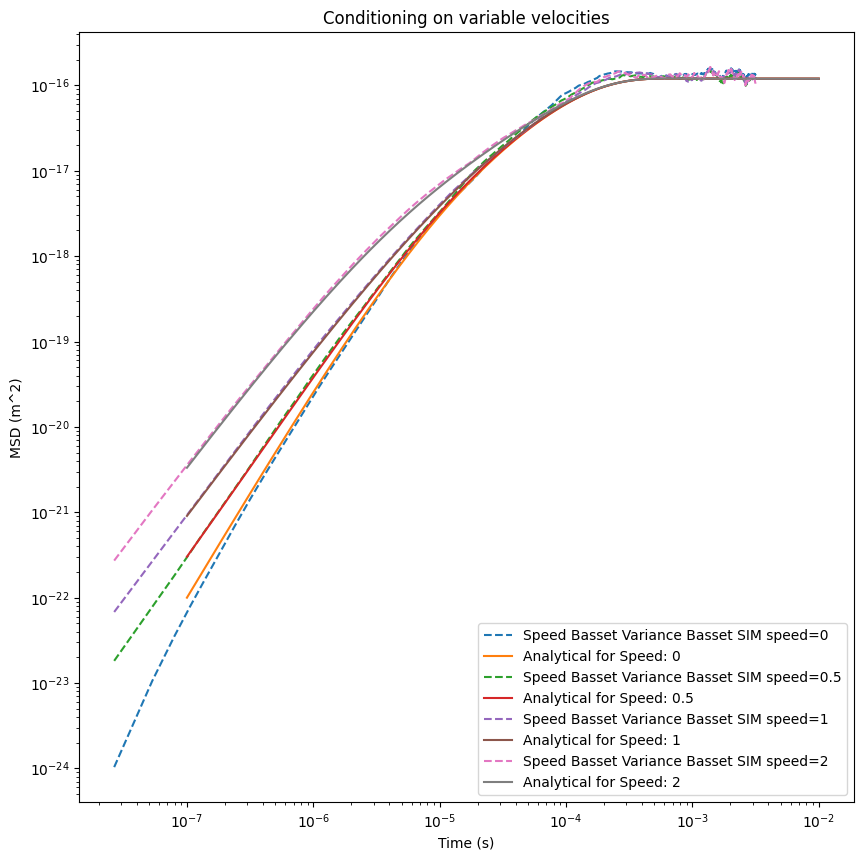

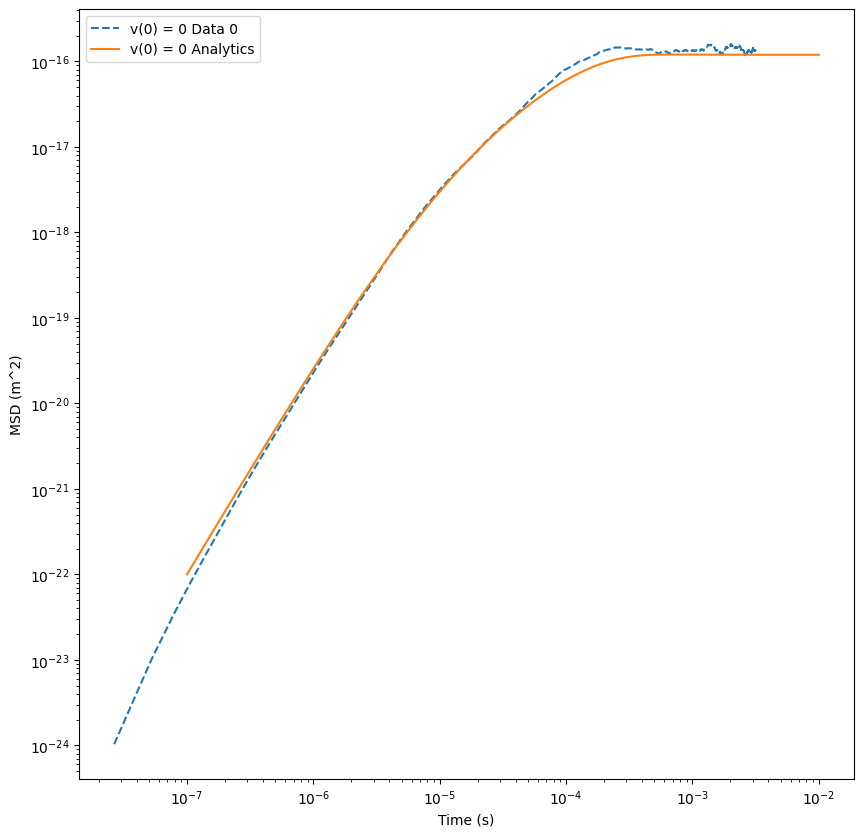

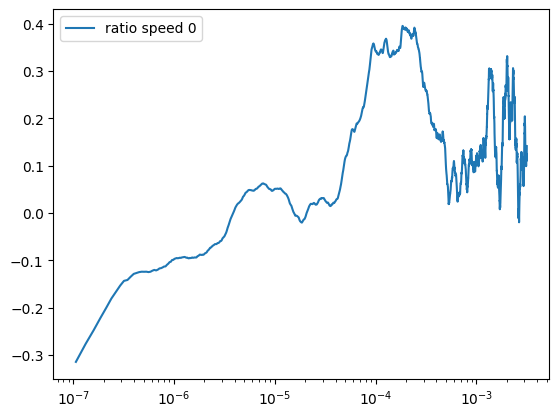

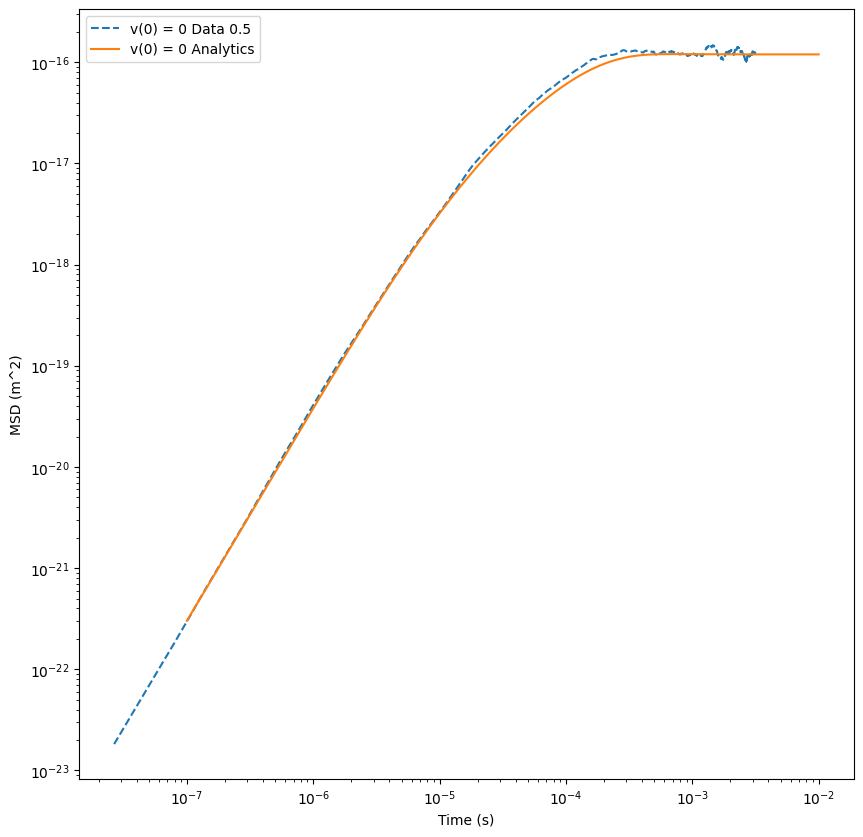

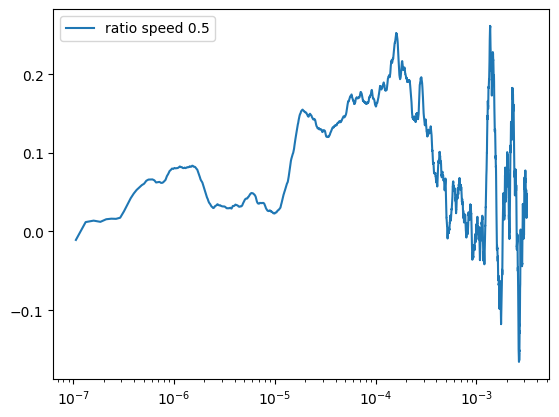

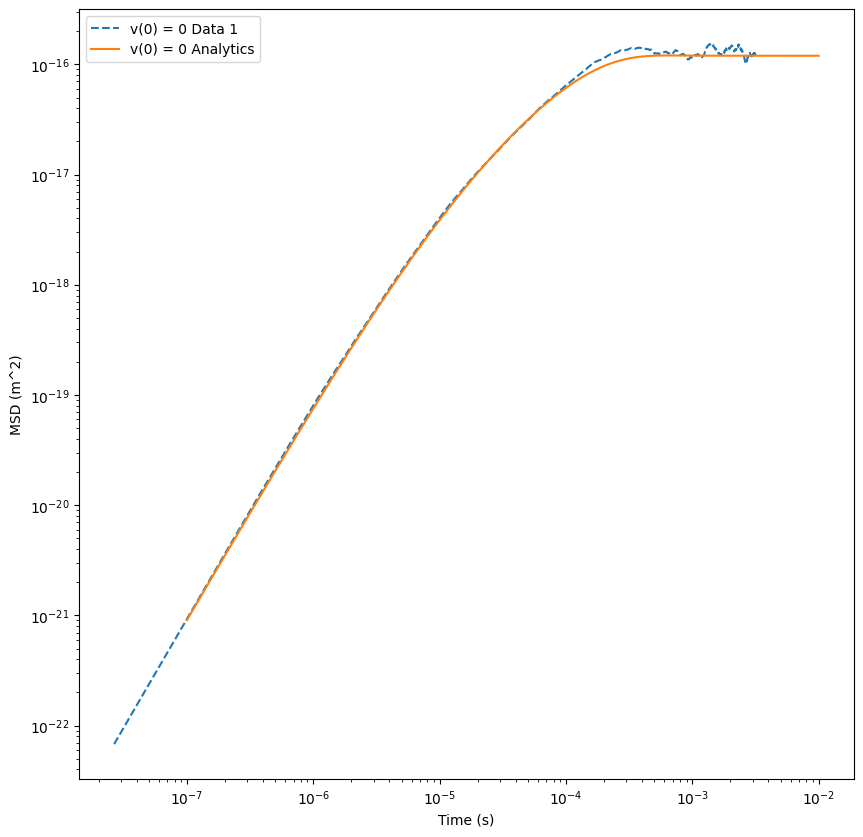

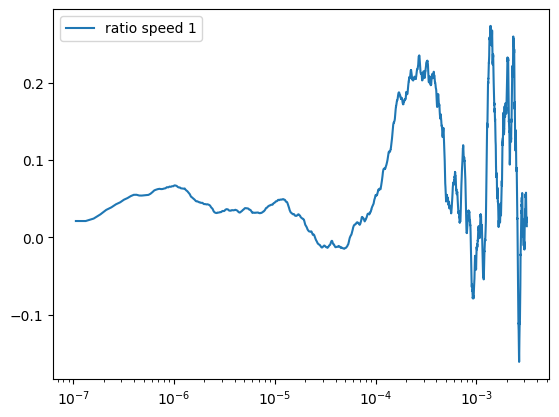

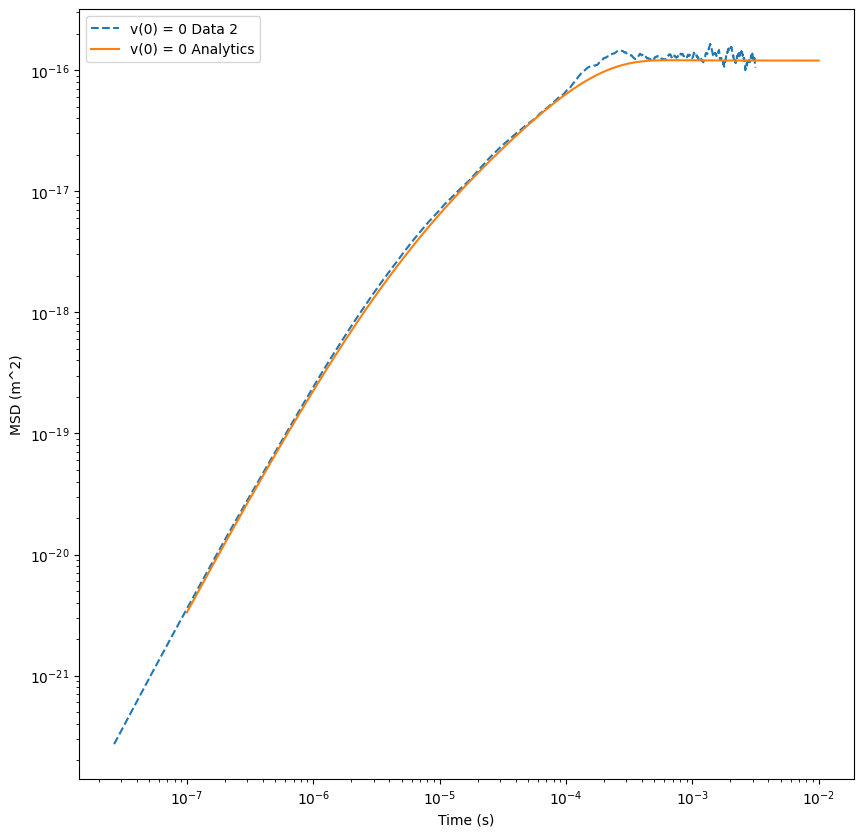

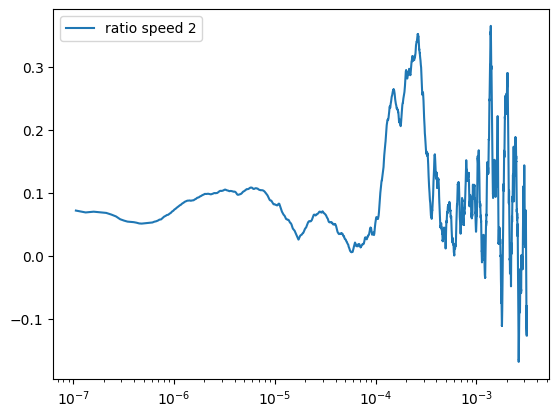

In [23]:
# GRAPHING

basset_msd = hydro_msd(times_analytic)

# ANALYTIC GRAPHING
plt.figure(figsize=(10,10))
plt.plot(times_analytic, basset_msd, color='green', linewidth=4,label="Equilibrium Basset")

# SIMULATION GRAPHING
plt.plot(lag_times_sim, eq_msd_sim, color = "red", label="Equilibrium Basset SIM")
# plt.plot(init_lag_times_sim[1:], sim_tol_msds[-1][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[0]}")
# for i in range(len(tols)):
    # plt.plot(init_lag_times_sim[40:], sim_tol_msds[i][40:]*_gain**2, linestyle = 'dashed', color = "red", label=f"Initial Variable Basset Variance Basset SIM tol={tols[i]}")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# SPEEDS
plt.figure(figsize=(10,10))
for i in range(0, len(speeds)):
    plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[i][1:], linestyle = 'dashed', label=f"Speed Basset Variance Basset SIM speed={speeds[i]}")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xlabel("Time (s)")
plt.ylabel("MSD (m^2)")
plt.title("Conditioning on variable velocities")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


for i in range(0, len(speeds)):
    plt.figure(figsize=(10,10))
    plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[i][1:], linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[i]}")
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"v(0) = 0 Analytics")

    plt.xlabel("Time (s)")
    plt.ylabel("MSD (m^2)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # interp and diff
    from scipy.interpolate import interp1d

    mask = lag_times_speed_sim[1:] > 1e-7

    domain = lag_times_speed_sim[1:][mask]

    interpo = interp1d(times_analytic, speeds_analytic_no_half[i])
    analytic_interp = interpo(domain)

    # plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[0][1:], linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
    plt.plot(domain, (sim_speeds_msds[i][1:][mask]-analytic_interp)/analytic_interp, label=f"ratio speed {speeds[i]}")
    plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()


In [11]:
import pandas as pd

# Load the data
df = pd.read_csv(r"..\data\total_data.txt", sep="\t")
t_evals = df['t_evals'].values
total_hist_value = df['Total_Value'].values


interpo = interp1d(t_evals, total_hist_value)
total_hist_interp = interpo(domain)

# plt.plot(lag_times_speed_sim[1:], sim_speeds_msds[0][1:], linestyle = 'dashed', label=f"v(0) = 0 Data {speeds[0]}")
plt.plot(domain, (sim_speeds_msds[0][1:][mask]-(analytic_interp+total_hist_interp))/(analytic_interp+total_hist_interp), label=f"total hist ratio")
plt.plot(domain, (sim_speeds_msds[0][1:][mask]-analytic_interp)/analytic_interp, label=f"ratio")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


ValueError: A value (1.06227238091151e-07) in x_new is below the interpolation range's minimum value (3.162277660168379e-07).